In [168]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import yfinance as yf
from statsmodels.sandbox.tools import tools_pca
from sklearn.decomposition import PCA

In [3]:
def compareModelGraph(model1, model2):
    plt.figure(figsize=(15, 10))
    plt.rcParams["font.size"] = "20"
    plt.plot(range(len(model1.yTest)), model1.yTest, label="real")
    plt.plot(range(len(model1.yPred)), model1.yPred, label="model1")
    plt.plot(range(len(model2.yPred)), model2.yPred, label="model2")
    plt.ylabel("y", fontsize=15)
    plt.xlabel("x", fontsize=15)
    plt.legend(loc="lower right", fontsize=15)
    plt.show()
    return

In [313]:
class MLP:
    def __init__(self, xyTrainTest, batchNorm=None, layerN=3, actFunc="relu", nn=64, alpha=0):
        actFuncDict = {"relu": tf.keras.layers.ReLU(negative_slope=alpha), "tanh": tf.keras.layers.Activation('tanh')}
        assert isinstance(xyTrainTest, (list, tuple)) and (len(xyTrainTest) == 4)
        assert isinstance(actFunc, str) and actFunc.lower() in actFuncDict.keys()
        assert (batchNorm is None) or isinstance(batchNorm, (int, list))
        assert layerN > 0
        self.xTrain, self.yTrain, self.xTest, self.yTest = xyTrainTest
        self.trainLen = len(self.xTrain)
        self.layerN = layerN
        self.batchNorm = batchNorm
        self.actFunc = actFuncDict.get(actFunc.lower())
        self.nn = nn
        return
    
    def buildModel(self):
        layerN = self.layerN
        batchNorm = self.batchNorm
        model = tf.keras.models.Sequential()
        for i in range(1,(layerN+1)):
            model.add(tf.keras.layers.Dense(self.nn, activation=self.actFunc))
            if batchNorm and ((i == batchNorm) or (i in batchNorm)):
                model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss="mse",  metrics=[tf.keras.metrics.RootMeanSquaredError()])
        
        return model

    def train(self, bs=32, ntry=10):
        validLen = math.ceil(self.trainLen * 0.2)
        model = self.buildModel()
        model.fit(self.xTrain, self.yTrain, batch_size=bs, epochs=100, shuffle=True, verbose=0)
        self.bestModel = model
        bestLoss = model.evaluate(self.xTrain[-validLen:], self.yTrain[-validLen:])
        
        for i in range(ntry):
            model = self.buildModel()
            model.fit(self.xTrain, self.yTrain, batch_size=bs, epochs=100, shuffle=True, verbose=0)
            if model.evaluate(self.xTrain, self.yTrain) < bestLoss:
                self.bestModel = model
                bestLoss = model.evaluate(self.xTrain[-validLen:], self.yTrain[-validLen:])
        return bestLoss

    def predict(self):
        self.yPred = self.bestModel.predict(self.xTest)
        return
    
    def RMSE(self):
        self.rmse = np.sqrt(np.mean(np.square(self.yTest-self.yPred)))
        return
    
    def genGraph(self, l=None, h=None):
        testLen = len(self.yTest)
        self.predict()
        yTest = self.yTest
        yPred = self.yPred
        if (l is not None) and h is not None:
            yTest = yTest * (h-l) + l
            yPred = yPred * (h-l) + l

        plt.figure(figsize=(15, 10))
        plt.rcParams["font.size"] = "20"
        plt.plot(range(testLen), yTest, label="true")
        plt.plot(range(testLen), yPred, label="predict")
#         plt.title(f"{} {}")
        plt.ylabel("y", fontsize=15)
        plt.xlabel("x", fontsize=15)
        plt.legend(loc="lower right", fontsize=15)
        plt.show()
        return

In [439]:
class Data:
    def __init__(self, start="2012-03-01", end="2022-03-01", fed=False ,facDict=None):
        assert facDict is None or isinstance(facDict, dict)
        self.oilPrice = yf.download("CL=F", start=start, end=end).loc[:,["Close"]]
        if facDict is None:
            self.facDf = pd.DataFrame()
        else:
            factors = list(set([i for arr in facDict.values() for i in arr]))
            mulIdx = pd.MultiIndex.from_tuples([(key, val) for key in facDict.keys() for val in facDict.get(key)])
            if len(factors) == 1:
                mulIdx = list(facDict.keys())
            facDf = yf.download(factors, start=start, end=end).loc[:, mulIdx]
            if facDf.columns.nlevels > 1:
                facDf.columns = [" ".join(pair[::-1]) for pair in facDf.columns]
            self.facDf = facDf
        if fed:
            self.fedDf = pd.read_csv("./dataset/fed.csv", index_col=0, parse_dates=True)
        else:
            self.fedDf = pd.DataFrame()
        self.df = self.oilPrice.join([self.facDf, self.fedDf])
        return
    
    def generate_train_test(self, df, seqLen, covid=True, split=0.8, trainLen=None, norm=False):
        if not covid:
            df = df.loc[df.index < "2020-03-01"] 
        if trainLen is None:
            trainLen = math.ceil(len(df) * split)
        train = df.iloc[:trainLen]
        test = df.iloc[trainLen:]
        if norm:
            l = train.min()
            print(l)
            h = train.max()
            print(h)
            self.l = l.iloc[0]
            self.h = h.iloc[0]
            train = (train - l)/(h-l)
            test = (test - l)/(h-l)

        xTrainL, yTrainL, xTestL, yTestL = [], [], [], []
        for i in range(len(train) - seqLen):
            xTrainL.append(train.iloc[i:(i+seqLen)].values.flatten("F"))
            yTrainL.append(train.iloc[(i+seqLen),0].flatten())
        for i in range(len(test) - seqLen):
            xTestL.append(test.iloc[i:(i+seqLen)].values.flatten("F"))
            yTestL.append(test.iloc[(i+seqLen),0].flatten())
        self.trainLen = trainLen
        self.testStartDate = df.index[trainLen]
        return [np.array(xTrainL), np.array(yTrainL), np.array(xTestL), np.array(yTestL)]

In [285]:
data = Data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [361]:
dataFed = Data(fed=True)

[*********************100%***********************]  1 of 1 completed


In [440]:
facDict = {"Volume": ["CL=F"]}
dataVol = Data(facDict=facDict)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
tf.random.set_seed(4012)

In [209]:
start = "2012-03-01"
end = "2022-03-01"
facDict = {"Close": ["OXY", "DX-Y.NYB"], "Volume": ["CL=F"]}
data = Data(fed=True)

TypeError: __init__() got an unexpected keyword argument 'fed'

In [299]:
modelP = MLP(data.generate_train_test(data.df, 5, covid=False), alpha=0)
modelP.train()

51/51 [==============================] - 0s 861us/step - loss: 5481.0610 - root_mean_squared_error: 74.0342


[1.1827794313430786, 1.0875566005706787]

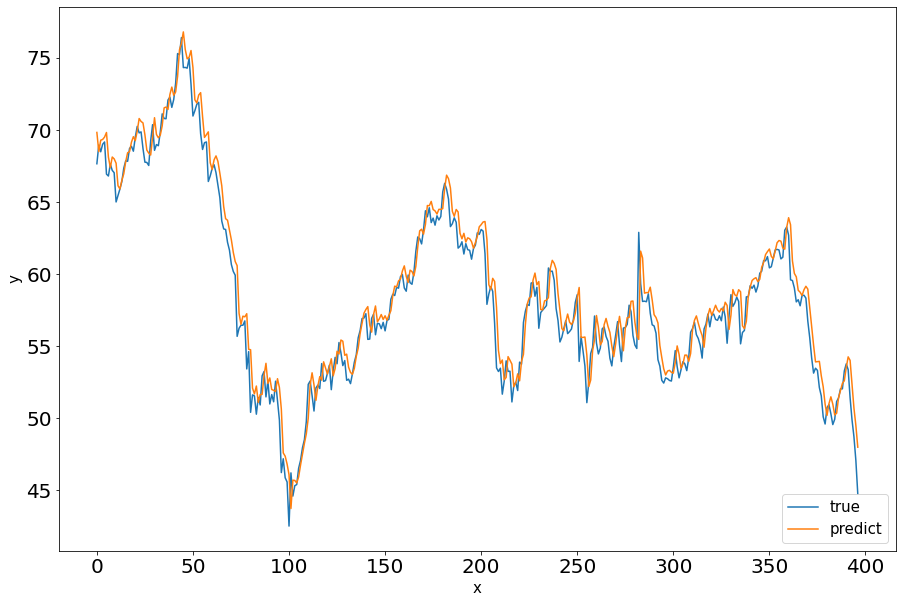

In [342]:
modelP.genGraph()

In [449]:
# modelP_Fed = MLP(data.generate_train_test(data.df, 2, covid=False), alpha=0)
# modelP_Fed.train()

In [ ]:
modelP_Fed.genGraph()

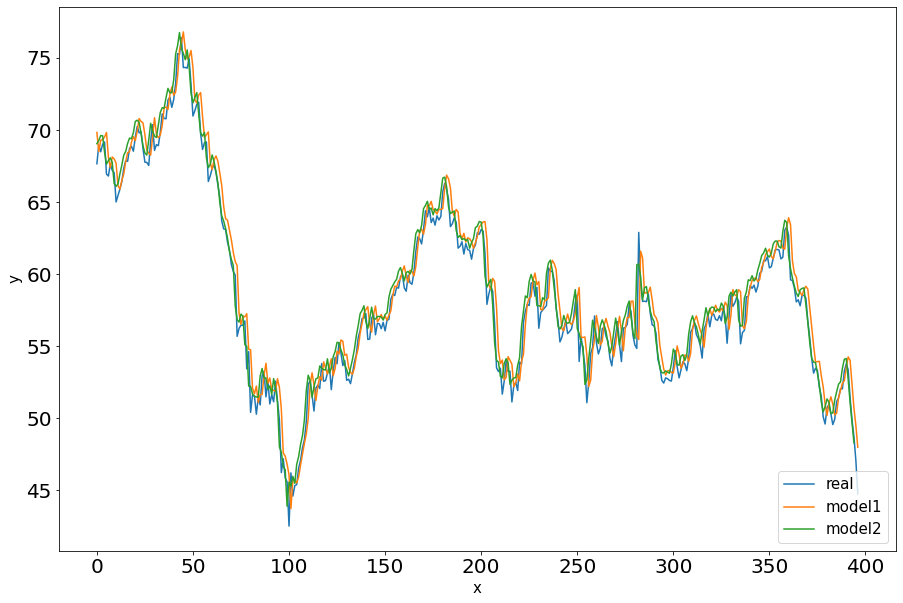

In [350]:
compareModelGraph(modelP, modelP_Fed)

In [351]:
modelP_Fed = MLP(data.generate_train_test(data.df, 5, covid=False), alpha=0)
modelP_Fed.train()

51/51 [==============================] - 0s 845us/step - loss: 5488.1519 - root_mean_squared_error: 74.0821


[2.110330581665039, 1.4526976346969604]

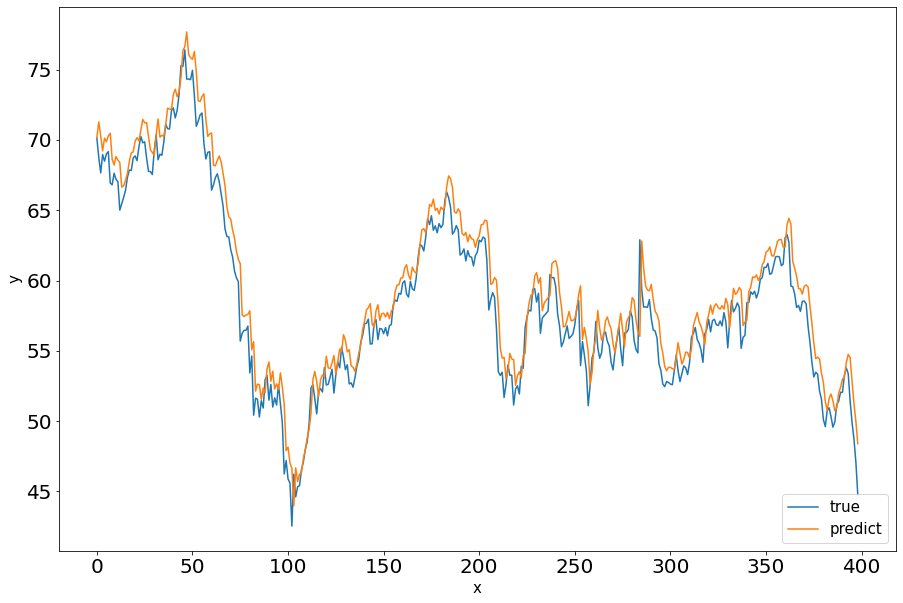

In [352]:
modelP_Fed.genGraph()

In [335]:
data.df

,Close
Date,
2012-02-29,107.070000
2012-03-01,108.839996
2012-03-02,106.699997
2012-03-05,106.720001
2012-03-06,104.699997
...,...
2022-02-22,92.349998
2022-02-23,92.099998
2022-02-24,92.809998


In [354]:
data.df

,Close
Date,
2012-02-29,107.070000
2012-03-01,108.839996
2012-03-02,106.699997
2012-03-05,106.720001
2012-03-06,104.699997
...,...
2022-02-22,92.349998
2022-02-23,92.099998
2022-02-24,92.809998


In [364]:
dataFed.df.iloc[:,1:].cov()

,DFF,DFII10,DGS1MO,DGS2,DGS10
DFF,0.597459,0.239044,0.604280,0.559926,0.190963
DFII10,0.239044,0.370328,0.235487,0.312591,0.309730
DGS1MO,0.604280,0.235487,0.618079,0.569812,0.192149
DGS2,0.559926,0.312591,0.569812,0.618759,0.278106
DGS10,0.190963,0.309730,0.192149,0.278106,0.370925


In [367]:
pca = PCA(0.95)
pca.fit_transform(dataFed.df.iloc[:,1:].ffill())

array([[-0.99266502,  0.09592241],
       [-0.96424597,  0.15889631],
       [-0.99402668,  0.13036978],
       ...,
       [-0.44958087, -0.12988221],
       [-0.44600482, -0.10519629],
       [-0.59342403, -0.33387429]])

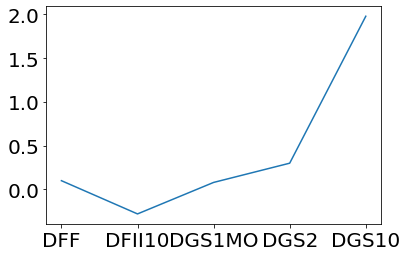

In [382]:
diff = dataFed.df.iloc[:,1:] - dataFed.df.iloc[:,1:].shift()
plt.plot(dataFed.df.iloc[0,1:])
plt.show()

In [390]:
rates = ["DGS1MO", "DGS3MO", "DGS6MO", "DGS1", "DGS2", "DGS3", "DGS5", "DGS7", "DGS10"]
rates = [pd.read_csv(f"./dataset/{rate}.csv", index_col=0, parse_dates=True).replace(".", np.nan).astype("float64") for rate in rates]
ratesDf = pd.concat(rates, axis=1)
ratesDf = ratesDf.dropna(how="all")

In [402]:
ratesDf.iloc[:,1] = (ratesDf.iloc[:,1]/12 + 1) ** 3 / (ratesDf.iloc[:,1]/12 + 1)

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10
DATE,,,,,,,,,
2012-02-29,0.08,0.08,0.13,0.18,0.30,0.43,0.87,1.39,1.98
2012-03-01,0.07,0.08,0.13,0.18,0.30,0.43,0.89,1.44,2.03
2012-03-02,0.06,0.07,0.12,0.17,0.28,0.41,0.84,1.38,1.99
2012-03-05,0.07,0.08,0.14,0.17,0.31,0.43,0.87,1.40,2.00
2012-03-06,0.06,0.08,0.13,0.17,0.30,0.40,0.83,1.35,1.96
...,...,...,...,...,...,...,...,...,...
2022-02-22,0.03,0.37,0.73,1.17,1.56,1.74,1.85,1.93,1.94
2022-02-23,0.02,0.34,0.74,1.16,1.58,1.78,1.89,1.98,1.99
2022-02-24,0.05,0.32,0.65,1.08,1.54,1.73,1.84,1.94,1.96


In [418]:
np.log(ratesDf.iloc[:,0]/12 + 1)*12

DATE
2012-02-29    0.079735
2012-03-01    0.069797
2012-03-02    0.059850
2012-03-05    0.069797
2012-03-06    0.059850
                ...   
2022-02-22    0.029963
2022-02-23    0.019983
2022-02-24    0.049896
2022-02-25    0.029963
2022-02-28    0.059850
Name: DGS1MO, Length: 2502, dtype: float64

In [420]:
np.log(ratesDf.iloc[:,1]/4 + 1)*4

DATE
2012-02-29    0.079211
2012-03-01    0.079211
2012-03-02    0.069395
2012-03-05    0.079211
2012-03-06    0.079211
                ...   
2022-02-22    0.353875
2022-02-23    0.326320
2022-02-24    0.307844
2022-02-25    0.317093
2022-02-28    0.335526
Name: DGS3MO, Length: 2502, dtype: float64

In [422]:
np.log(ratesDf.iloc[:,2]/2 + 1)*2

DATE
2012-02-29    0.125950
2012-03-01    0.125950
2012-03-02    0.116538
2012-03-05    0.135317
2012-03-06    0.125950
                ...   
2022-02-22    0.622309
2022-02-23    0.629621
2022-02-24    0.562825
2022-02-25    0.607603
2022-02-28    0.592788
Name: DGS6MO, Length: 2502, dtype: float64

In [423]:
np.log(ratesDf.iloc[:,3] + 1)

DATE
2012-02-29    0.165514
2012-03-01    0.165514
2012-03-02    0.157004
2012-03-05    0.157004
2012-03-06    0.157004
                ...   
2022-02-22    0.774727
2022-02-23    0.770108
2022-02-24    0.732368
2022-02-25    0.756122
2022-02-28    0.698135
Name: DGS1, Length: 2502, dtype: float64

In [424]:
np.log((ratesDf.iloc[:,4] + 1) ** 2)/2

DATE
2012-02-29    0.262364
2012-03-01    0.262364
2012-03-02    0.246860
2012-03-05    0.270027
2012-03-06    0.262364
                ...   
2022-02-22    0.940007
2022-02-23    0.947789
2022-02-24    0.932164
2022-02-25    0.936093
2022-02-28    0.891998
Name: DGS2, Length: 2502, dtype: float64

In [425]:
np.log((ratesDf.iloc[:,5] + 1) ** 3)/3

DATE
2012-02-29    0.357674
2012-03-01    0.357674
2012-03-02    0.343590
2012-03-05    0.357674
2012-03-06    0.336472
                ...   
2022-02-22    1.007958
2022-02-23    1.022451
2022-02-24    1.004302
2022-02-25    1.015231
2022-02-28    0.963174
Name: DGS3, Length: 2502, dtype: float64

In [428]:
np.log((ratesDf.iloc[:,6] + 1) ** 5)/5

DATE
2012-02-29    0.625938
2012-03-01    0.636577
2012-03-02    0.609766
2012-03-05    0.625938
2012-03-06    0.604316
                ...   
2022-02-22    1.047319
2022-02-23    1.061257
2022-02-24    1.043804
2022-02-25    1.050822
2022-02-28    0.996949
Name: DGS5, Length: 2502, dtype: float64

In [429]:
np.log((ratesDf.iloc[:,7] + 1) ** 7)/7

DATE
2012-02-29    0.871293
2012-03-01    0.891998
2012-03-02    0.867100
2012-03-05    0.875469
2012-03-06    0.854415
                ...   
2022-02-22    1.075002
2022-02-23    1.091923
2022-02-24    1.078410
2022-02-25    1.085189
2022-02-28    1.033184
Name: DGS7, Length: 2502, dtype: float64

In [430]:
np.log((ratesDf.iloc[:,8] + 1) ** 10)/10

DATE
2012-02-29    1.091923
2012-03-01    1.108563
2012-03-02    1.095273
2012-03-05    1.098612
2012-03-06    1.085189
                ...   
2022-02-22    1.078410
2022-02-23    1.095273
2022-02-24    1.085189
2022-02-25    1.088562
2022-02-28    1.040277
Name: DGS10, Length: 2502, dtype: float64

In [413]:
((((ratesDf.iloc[:,1]/12 + 1) ** 3 / (ratesDf.iloc[:,0]/12 + 1) ** 1) ** 0.5) - 1) * 12

DATE
2012-02-29    0.080000
2012-03-01    0.085003
2012-03-02    0.075003
2012-03-05    0.085003
2012-03-06    0.090012
                ...   
2022-02-22    0.543587
2022-02-23    0.503181
2022-02-24    0.457260
2022-02-25    0.482794
2022-02-28    0.497605
Length: 2502, dtype: float64

In [416]:
((((ratesDf.iloc[:,2]/12 + 1) ** 6 / (ratesDf.iloc[:,1]/12 + 1) ** 3) ** (1/3)) - 1) * 12

DATE
2012-02-29    0.180207
2012-03-01    0.180207
2012-03-02    0.170207
2012-03-05    0.200298
2012-03-06    0.180207
                ...   
2022-02-22    1.100477
2022-02-23    1.152966
2022-02-24    0.988839
2022-02-25    1.101711
2022-02-28    1.039360
Length: 2502, dtype: float64

In [417]:
((((ratesDf.iloc[:,3] + 1) ** 1 / (ratesDf.iloc[:,2]/12 + 1) ** 6) ** (1/6)) - 1) * 12

DATE
2012-02-29    0.203433
2012-03-01    0.203433
2012-03-02    0.196190
2012-03-05    0.176097
2012-03-06    0.186135
                ...   
2022-02-22    0.870953
2022-02-23    0.850954
2022-02-24    0.861231
2022-02-25    0.851294
2022-02-28    0.747750
Length: 2502, dtype: float64

In [415]:
ratesDf.to_csv("./dataset/rates.csv")

In [447]:
modelPV = MLP(dataVol.generate_train_test(dataVol.df, 5, covid=False, norm=True), alpha=0)
modelPV.train()

Close        26.209999
Volume    48516.000000
dtype: float64
Close     1.105300e+02
Volume    1.311000e+06
dtype: float64
11/11 [==============================] - 0s 1ms/step - loss: 3.5810e-04 - root_mean_squared_error: 0.0189


[0.00035809926339425147, 0.01892351172864437]

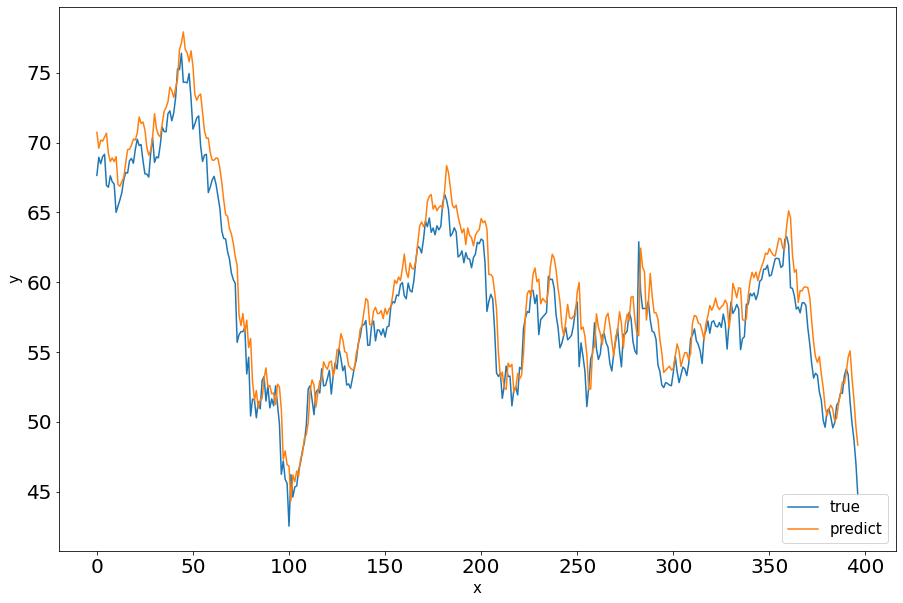

In [448]:
modelPV.genGraph(l=dataVol.l, h=dataVol.h)